## On Importe les librairies de base

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## On importe les données, on supprime les na et on normalise en données numérique le sexe

In [4]:
titanic = sns.load_dataset('titanic')
titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare']]
titanic.dropna(axis=0, inplace=True)
titanic['sex'].replace(['male', 'female'], [0, 1], inplace=True)
titanic.head()

,survived,pclass,sex,age,sibsp,fare
0,0,3,0,22.0,1,7.2500
1,1,1,1,38.0,1,71.2833
2,1,3,1,26.0,0,7.9250
3,1,1,1,35.0,1,53.1000
4,0,3,0,35.0,0,8.0500


## On commence l'EDA

6

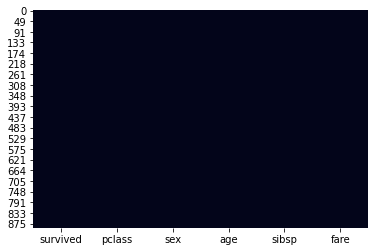

In [5]:
df = titanic.copy()
sns.heatmap(df.isna(), cbar=False)
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)
df.shape[0]
df.shape[1]

## Analyse des variables : corrélations

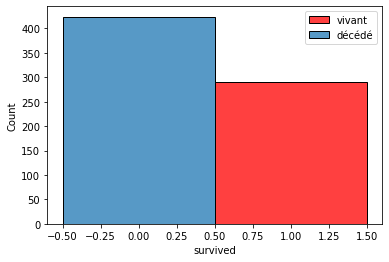

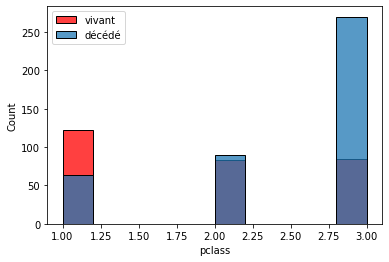

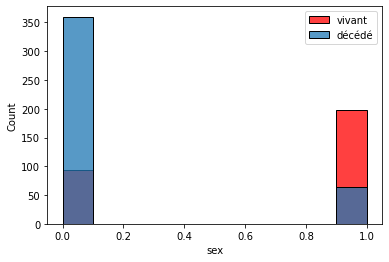

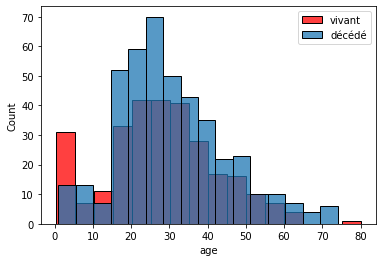

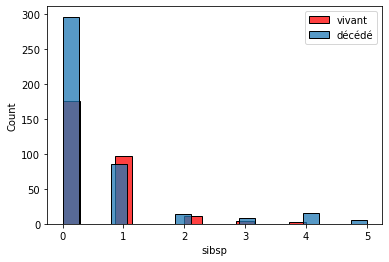

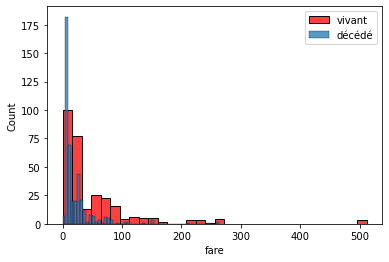

In [6]:
positive_df = df[df['survived'] == 1]
negative_df = df[df['survived'] == 0]


for col in df.columns:
    plt.figure()
    sns.histplot(positive_df[col], label='vivant', color ="r")
    sns.histplot(negative_df[col], label='décédé')
    plt.legend()

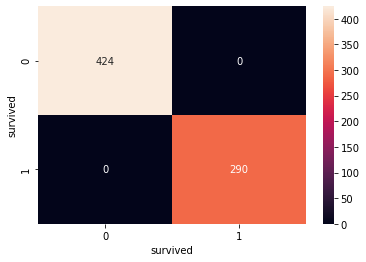

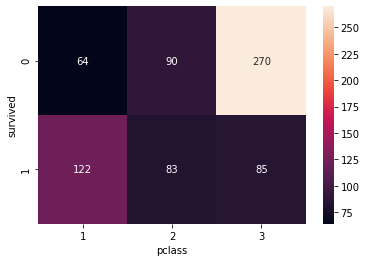

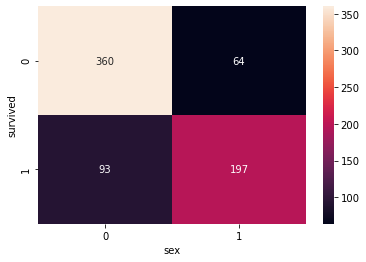

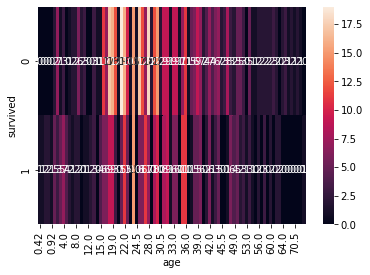

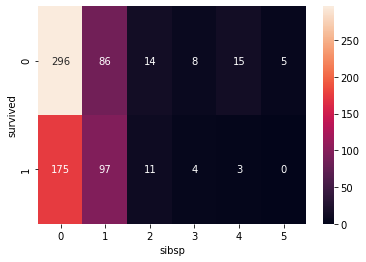

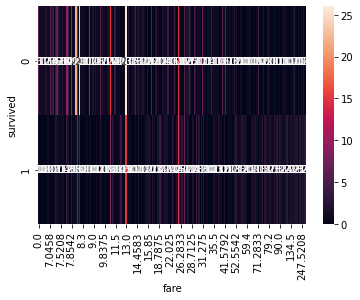

In [7]:
for col in df.columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df['survived'], df[col]), annot=True, fmt='d')

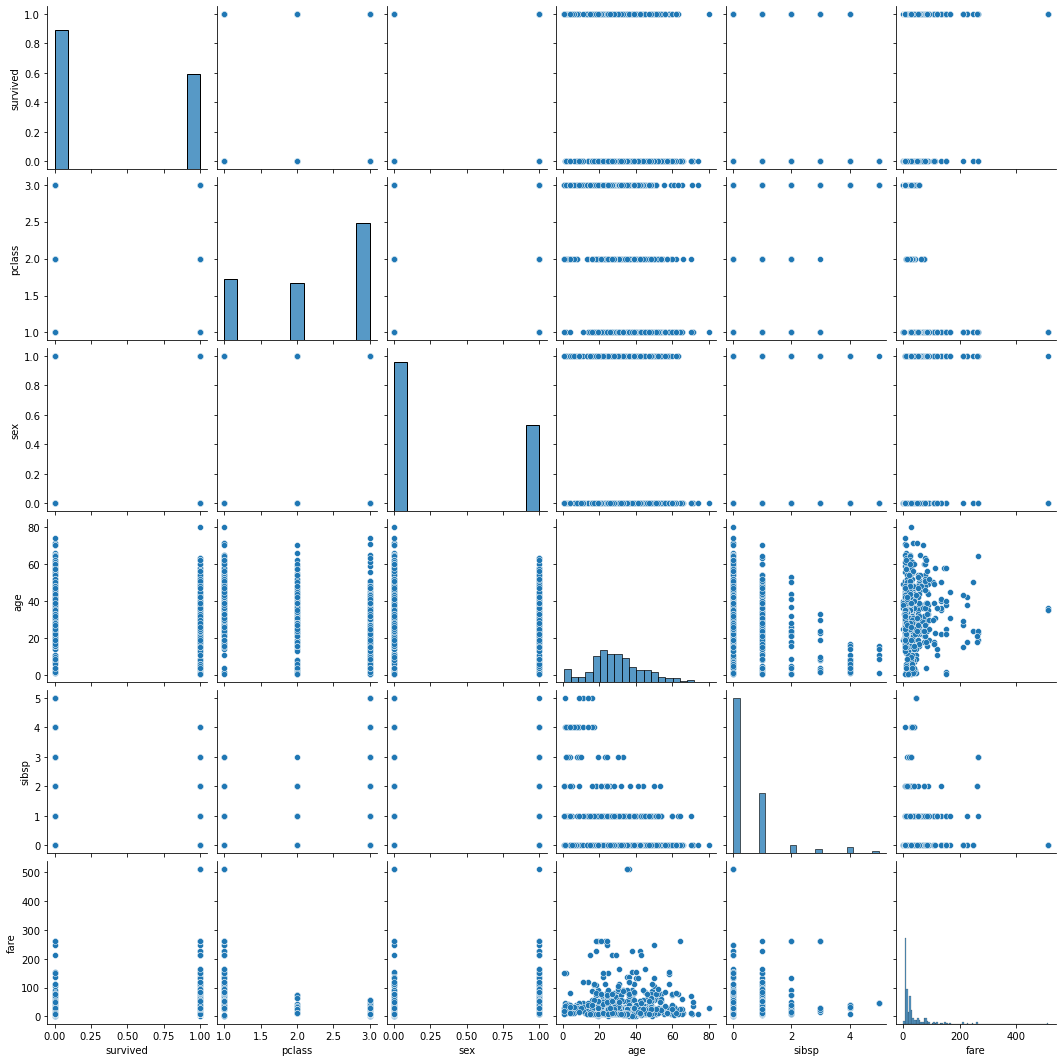

In [8]:
sns.pairplot(df)

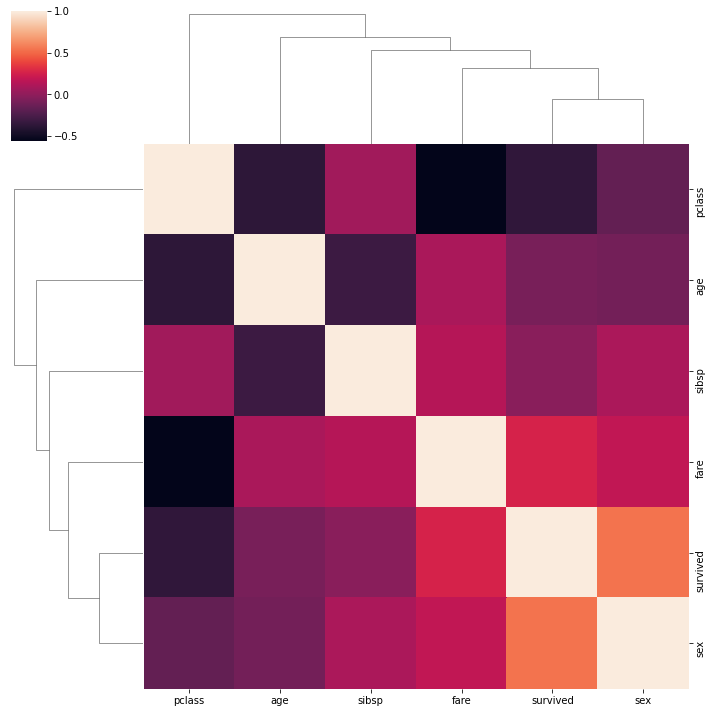

In [9]:
sns.clustermap(df.corr())

## On commence par normaliser les variables (même échelle)

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

titanic_norm = MinMaxScaler().fit_transform(titanic)
print(titanic_norm)

titanic = pd.DataFrame(titanic_norm, columns = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'fare'])


[[0.         1.         0.         0.27117366 0.2        0.01415106]
 [1.         0.         1.         0.4722292  0.2        0.13913574]
 [1.         1.         1.         0.32143755 0.         0.01546857]
 ...
 [1.         0.         1.         0.23347575 0.         0.0585561 ]
 [1.         0.         0.         0.32143755 0.         0.0585561 ]
 [0.         1.         0.         0.39683338 0.         0.01512699]]


## On sépare le dataset en données d'entrainement du modèle et de test du modèle

In [11]:
from sklearn.model_selection import train_test_split

# X doit être les données, et Y les targets (survie ou non)

y = titanic['survived']
X = titanic.drop('survived', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

Train set: (571, 5)
Test set: (143, 5)


## On entraine un premier modèle

In [12]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=1)

model_knn.fit(X_train, y_train)

print('train score:', model_knn.score(X_train, y_train))
print('test score:', model_knn.score(X_test, y_test))

train score: 0.9912434325744308
test score: 0.7622377622377622


## On essaie de l'améliorer via la cross-validation

In [13]:
from sklearn.model_selection import cross_val_score

model_knn = KNeighborsClassifier()
cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')

array([0.82608696, 0.81578947, 0.77192982, 0.81578947, 0.75438596])

## On s'intéresse à l'impact du nombre de voisins k sur la pertinence du modèle

C:\Users\viann\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


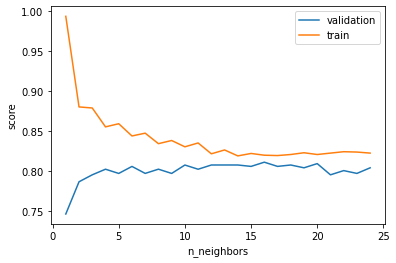

In [14]:
from sklearn.model_selection import validation_curve

model_knn = KNeighborsClassifier()
k = np.arange(1, 25)

train_score, val_score = validation_curve(model_knn, X_train, y_train,
                                          'n_neighbors', k, cv=5)

plt.plot(k, val_score.mean(axis=1), label='validation')
plt.plot(k, train_score.mean(axis=1), label='train')

plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

## On améliore le modèle en testant toute sortes de combinaisons de paramètres

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 20),
              'metric': ['euclidean', 'manhattan'],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']})

In [17]:
print(grid.best_score_)
print(grid.best_params_)

0.8196033562166285
{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


In [18]:
model_knn = grid.best_estimator_
model_knn.score(X_test, y_test)

0.7972027972027972

## On analyse maintenant la qualité du modèle KNN

In [24]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

[[79  9]
 [20 35]]
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.84        88
         1.0       0.80      0.64      0.71        55

    accuracy                           0.80       143
   macro avg       0.80      0.77      0.78       143
weighted avg       0.80      0.80      0.79       143



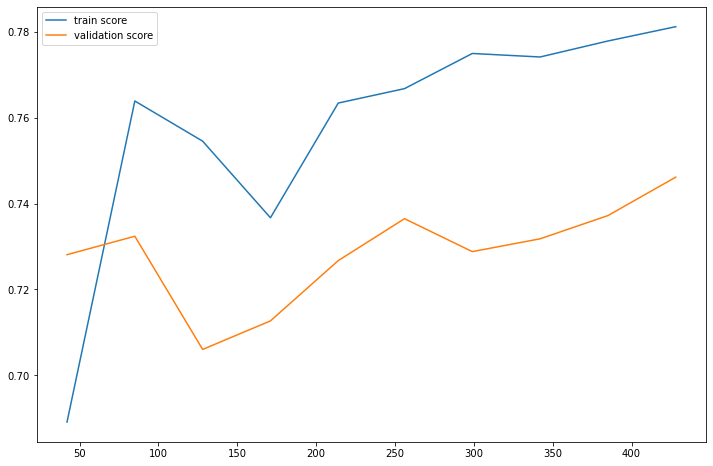

In [25]:
evaluation(model_knn)

<AxesSubplot:>

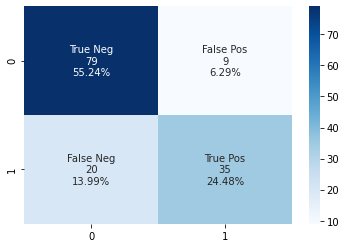

In [27]:
cf_matrix = confusion_matrix(y_test, model_knn.predict(X_test))
labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

[ 45  91 136 182 228 273 319 364 410 456]


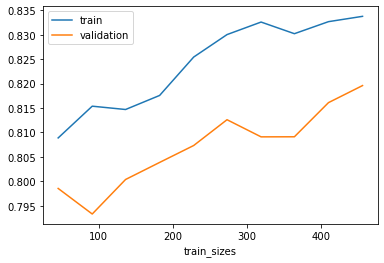

In [28]:
N, train_score, val_score = learning_curve(model_knn, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures

## On teste un nouveau modèle en RandomForest

In [30]:
model_randomf = make_pipeline(PolynomialFeatures(2), SelectKBest(f_classif, k=5),
                      RandomForestClassifier(random_state=0))

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[[76 12]
 [20 35]]
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.83        88
         1.0       0.74      0.64      0.69        55

    accuracy                           0.78       143
   macro avg       0.77      0.75      0.76       143
weighted avg       0.77      0.78      0.77       143



C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\viann\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\viann\anaconda3\lib\sit

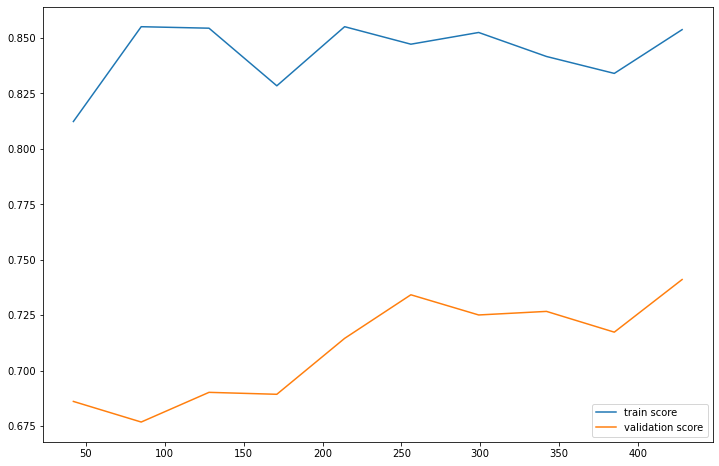

In [31]:
evaluation(model_randomf)

## On exporte le modèle en .pkl pour usages futurs

In [33]:
import pickle

Pkl_Filename = "model_titanic.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_knn, file)

In [36]:
with open(Pkl_Filename, 'rb') as file:  
    pickled_model = pickle.load(file)

pickled_model

test_ultime = pd.read_csv("test.csv")
test_ultime = test_ultime[[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Fare']]
test_ultime.dropna(axis=0, inplace=True)
test_ultime['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
print(test_ultime.head(5))

test_ultime = MinMaxScaler().fit_transform(test_ultime)

test_ultime = pd.DataFrame(test_ultime, columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare'])

Ypredict = pickled_model.predict(test_ultime)  

Ypredict


df_final = pd.DataFrame(Ypredict, columns = ['Survived'])


df_final['Survived'].value_counts()


   Pclass  Sex   Age  SibSp     Fare
0       3    0  34.5      0   7.8292
1       3    1  47.0      1   7.0000
2       2    0  62.0      0   9.6875
3       3    0  27.0      0   8.6625
4       3    1  22.0      1  12.2875


0.0    214
1.0    117
Name: Survived, dtype: int64